## **House Price Prediction**

In [39]:
# 필요한 라이브러리 import
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, cross_val_score

from scipy.stats import randint, uniform

import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
# 데이터불러오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('--')

--


### 데이터 살펴보기(EDA)

In [41]:
print(train.shape)
print(test.shape)

(15035, 21)
(6468, 20)


In [42]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [43]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


### 전처리 진행하기

<AxesSubplot:>

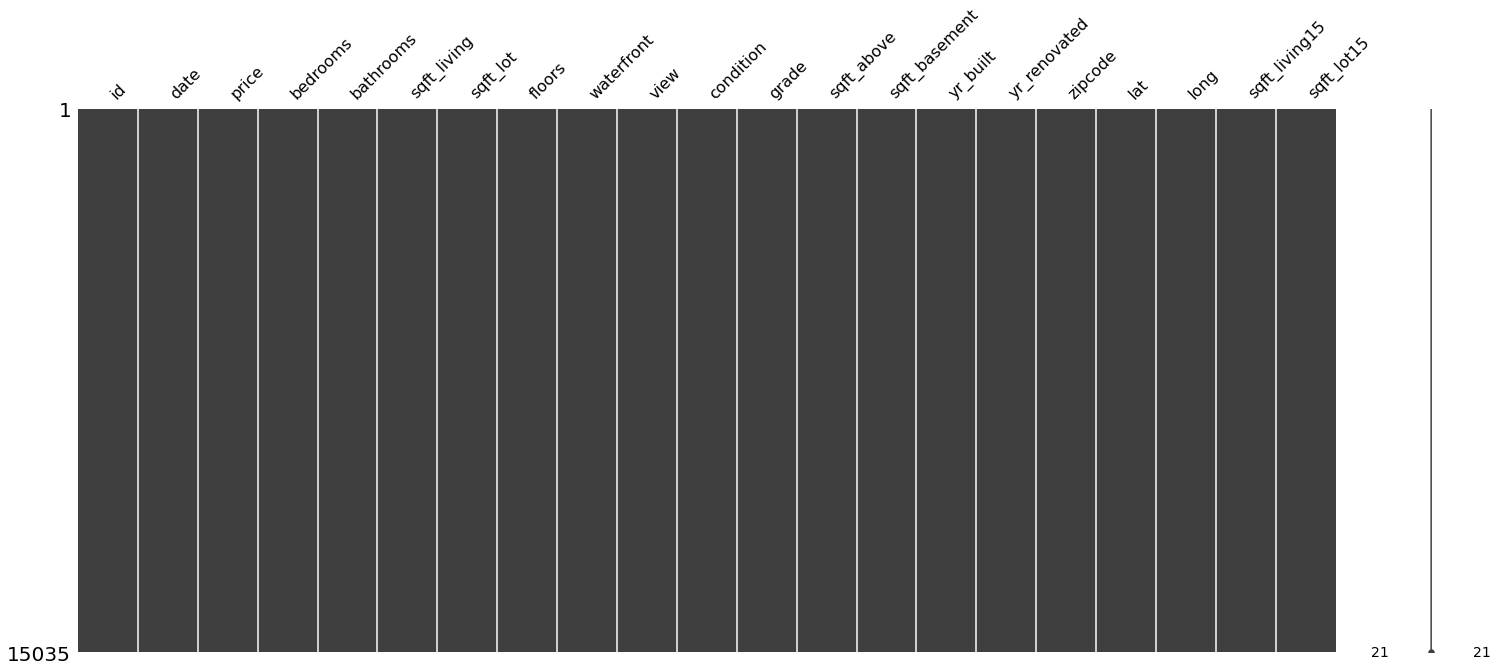

In [44]:
msno.matrix(train)

<AxesSubplot:>

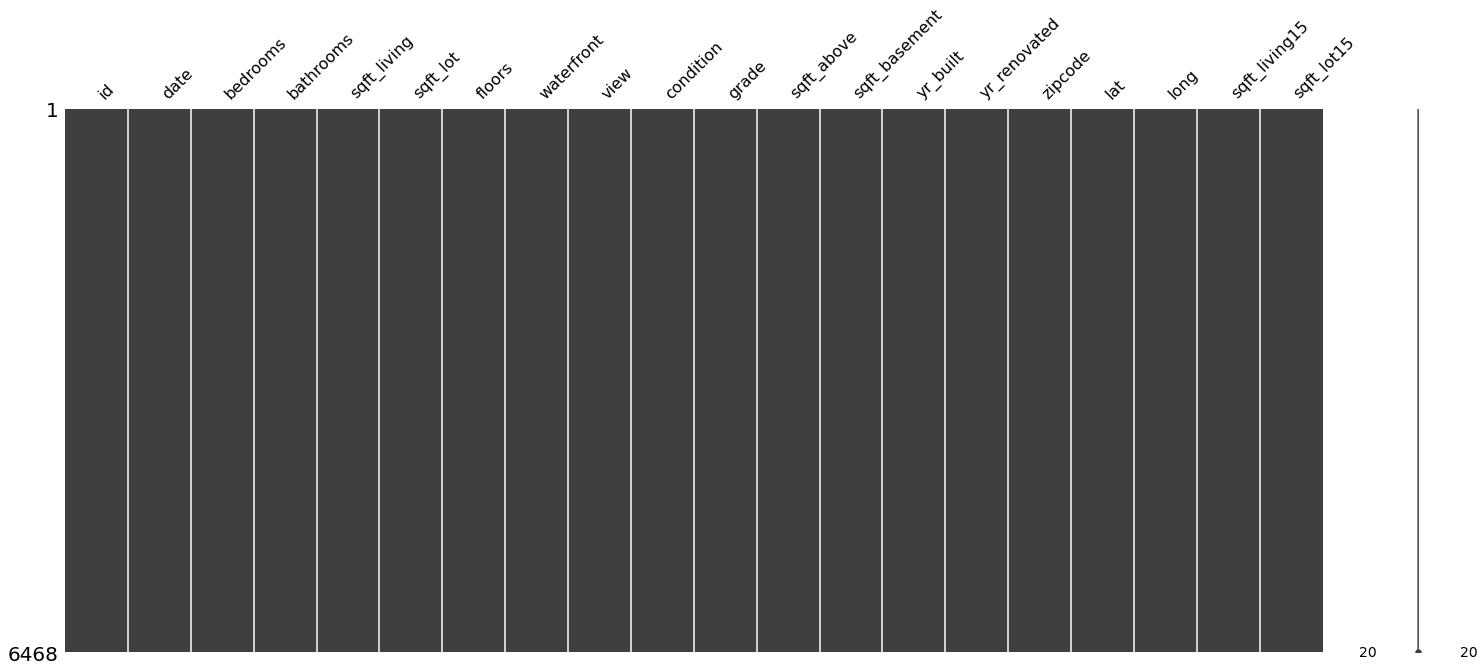

In [45]:
msno.matrix(test)

test, train 데이터에 결측치가 없는 것으로 확인할 수 있다.

In [46]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             6468 non-null   int64  
 1   date           6468 non-null   object 
 2   bedrooms       6468 non-null   int64  
 3   bathrooms      6468 non-null   float64
 4   sqft_living    6468 non-null   int64  
 5   sqft_lot       6468 non-null   int64  
 6   floors         6468 non-null   float64
 7   waterfront     6468 non-null   int64  
 8   view           6468 non-null   int64  
 9   condition      6468 non-null   int64  
 10  grade          6468 non-null   int64  
 11  sqft_above     6468 non-null   int64  
 12  sqft_basement  6468 non-null   int64  
 13  yr_built       6468 non-null   int64  
 14  yr_renovated   6468 non-null   int64  
 15  zipcode        6468 non-null   int64  
 16  lat            6468 non-null   float64
 17  long           6468 non-null   float64
 18  sqft_liv

In [47]:
# 예측해야하는 price 값 test데이터에서 제거하기
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [48]:
# id 삭제
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [49]:
# id 삭제
del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [50]:
# train 데이터 date 정수형으로 변환(T000000삭제)
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [51]:
# date 정수형으로 변환(T000000삭제)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [52]:
# 타겟 데이터 확인
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

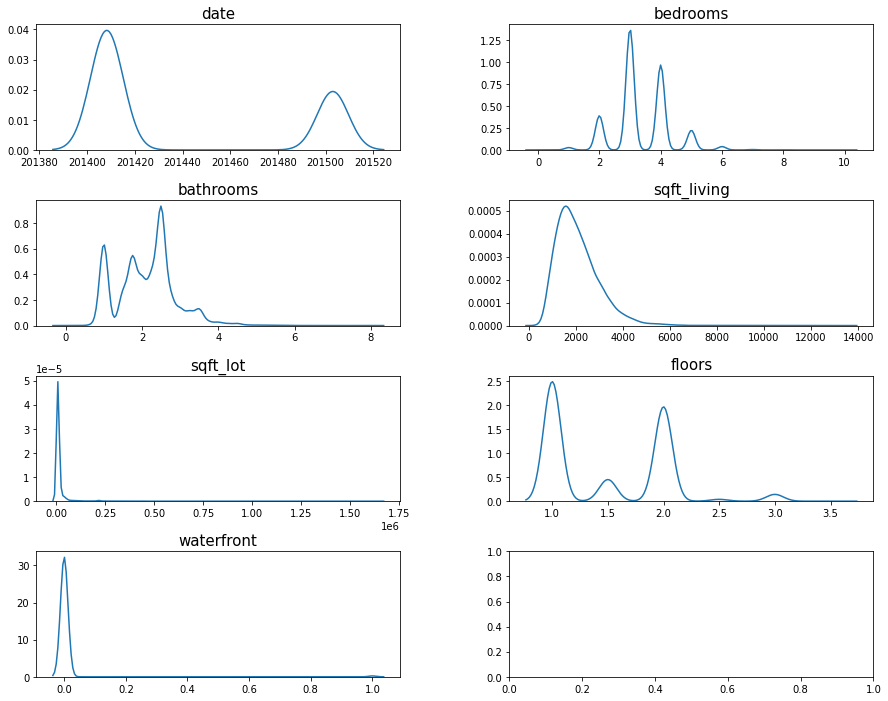

In [53]:
fig, ax = plt.subplots(4, 2, figsize=(15, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

count = 0
columns = train.columns
for row in range(4):
    for col in range(2):
        sns.kdeplot(train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        ax[row][col].set_xlabel('')
        ax[row][col].set_ylabel('')
        count += 1
        if count == 7:
            break

#### 로그변환

In [54]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

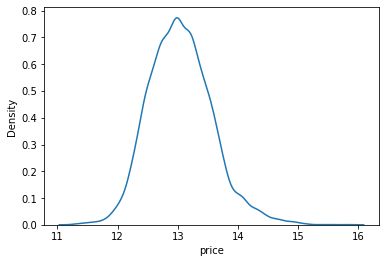

In [55]:
sns.kdeplot(y)
plt.show()

price값이 비교적 완만한 정규분포의 형태로 변환되었다.

### 모델링

In [56]:
# rmse 함수 정의
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [57]:
# random state 값 고정시키기
random_state = 33

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)
extrees = ExtraTreesRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest, extrees]

In [58]:
# get_scores 함수 정의
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__
        
        # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다.
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        
        # 모델 학습
        model.fit(X_train, y_train)
        
        # 예측 
        y_pred = model.predict(X_test)
        
        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)
        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df


In [59]:
get_scores(models, train, y)

,RMSE
RandomForestRegressor,123290.818121
GradientBoostingRegressor,118664.503189
ExtraTreesRegressor,116408.743664
LGBMRegressor,105715.362353
XGBRegressor,105342.454992


In [60]:
# my_GridSearch 함수 정의
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error',
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [61]:
# 그리드 탐색
param_grid = {
    'n_estimators': [1000, 1200],
    'max_depth': [5, 10, 15, 20],
    'learning_rate': [0.1, 0.01, 0.05],
    'subsample': [0.6, 0.7],
    'colsample_bytree': [0.6, 0.7],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=0.6; total time=   9.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=0.7; total time=   9.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=1200, subsample=0.6; total time=  11.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=1200, subsample=0.7; total time=  10.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=1000, subsample=0.6; total time=  12.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=1000, subsample=0.7; total time=  11.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=0.6; total time=  15.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=0.7; total time=  13.6s
[CV] E

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=0.6; total time=   9.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=0.7; total time=   9.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=1200, subsample=0.6; total time=  12.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=1200, subsample=0.7; total time=  13.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=1000, subsample=0.6; total time=  13.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=1000, subsample=0.7; total time=  13.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=0.6; total time=  15.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=0.7; total time=  16.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=15, n_es

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=0.6; total time=   8.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=0.7; total time=  11.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=1200, subsample=0.6; total time=  14.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=1200, subsample=0.7; total time=  12.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=1000, subsample=0.6; total time=  10.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=1000, subsample=0.7; total time=  13.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=0.6; total time=  16.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=0.7; total time=  15.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=15, n_es

,colsample_bytree,learning_rate,max_depth,n_estimators,subsample,score,RMSLE
36,0.6,0.05,10,1000,0.6,-0.025549,0.159841
37,0.6,0.05,10,1000,0.7,-0.025549,0.159841
32,0.6,0.05,5,1000,0.6,-0.025554,0.159856
33,0.6,0.05,5,1000,0.7,-0.025554,0.159856
34,0.6,0.05,5,1200,0.6,-0.025582,0.159944
...,...,...,...,...,...,...,...
67,0.7,0.01,5,1200,0.7,-0.027198,0.164917
65,0.7,0.01,5,1000,0.7,-0.027647,0.166273
64,0.7,0.01,5,1000,0.6,-0.027647,0.166273
16,0.6,0.01,5,1000,0.6,-0.027661,0.166315


In [63]:
# save_submission 함수 정의
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [64]:
model = LGBMRegressor(n_estimators=1000, max_depth=10, learning_rate=0.05, subsample=0.6, colsample_bytree=0.6, random_state=random_state)

print('--')

--


In [66]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.159841')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.159841.csv saved!


## **최종점수**

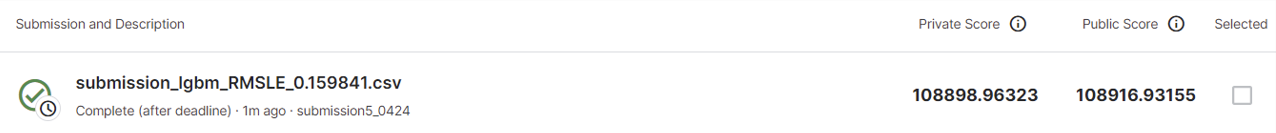

## **회고**

이번주에 데이터톤을 통해 배운 내용을 토대로 다시 작성해보았다. 하지만. 정규화를 시키면 시킬수록 성능이 좋지 않아져서 의문이 생겼다.
앞으로 많은 코드를 접하면서 이런저런 방법을 통해 성능이 어떻게 나오는지 많이 경험해봐야 할 것 같다. 추가로 노드도 따라 해보고 다른 코드도 작성해보면서 이 프로젝트를 차례대로 정렬하는 것 또한 어려웠지만, 제출은 성능 높이는 순서대로 따라 해보았다. 실제로 제출해서 얻는 점수가 더 낮아져서 아쉬웠지만, 앞으로 더 좋아지도록 노력할 것이다.